# 13.2.20224

### Total Living Area

Summing total 'GrLivArea' and 'TotalBsmtSF' results in 0.78 correlation with SalePrice. Worth trying adding this new feature and drop 'TotalBsmtsf' and 'GrLivArea', as well as 'BsmtFinSF2' and '2ndFlrSF'.

In [ ]:
area_df = train_origin_df.copy() # change to the correct df

def sum_area(column):
    return column['TotalBsmtSF'] + column['GrLivArea']

area_df["TotalArea"] = area_df.apply(sum_area, axis=1)

#columns that should probably be dropped:
columns_to_drop = ['TotalBsmtSF', 'GrLivArea', 'BsmtFinSF2', '2ndFlrSF']

#correlation with SalePrice:
area_df['TotalArea'].corr(area_df['SalePrice'])

0.7789588289942259

###Dropping SalePrice outliers

In [ ]:
filter_outliers_df = train_origin_df.copy() # change to the correct df

filter_outliers_df[filter_outliers_df['GrLivArea'] > 4000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


We want to drop 4 outliers samples that are at the far top end of the sale price scale, way above other deals.

In [ ]:
# Dropping the 4 samples with outliers
filter_outliers_df = filter_outliers_df[filter_outliers_df['GrLivArea'] <= 4000]

###Grouping exterior covering features ('Exterior1st', 'Exterior2nd')

Exterior covering has 2 features with 14 and 15 categories repectively - many of which are sparse. It seems beneficial to group them in order to reduce the spasity and complexity of the data.

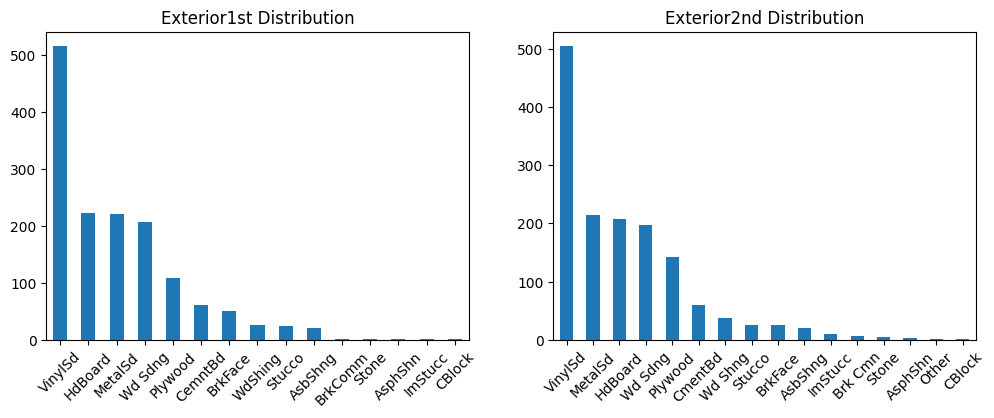

In [ ]:
import matplotlib.pyplot as plt

exterior_df = train_origin_df.copy() # change to the correct df

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
exterior_df['Exterior1st'].value_counts().plot(kind='bar', ax=axes[0], title='Exterior1st Distribution')
axes[0].tick_params(axis='x', rotation=45)
exterior_df['Exterior2nd'].value_counts().plot(kind='bar', ax=axes[1], title='Exterior2nd Distribution')
axes[1].tick_params(axis='x', rotation=45)
plt.show()

In [ ]:
# Grouping exterior covering categories into 6 groups
# Returns the same df but with the 2 new features *instead* of the 2 original ones

def group_exterior_covering(material):
    if material in ['Wd Sdng', 'Wd Shng', 'WdShing', 'AsphShn', 'Plywood']:  # Add or remove as per your dataset
        return 'Wood'
    elif material == 'VinylSd':
        return 'Vinyl'
    elif material in ['BrkComm', 'BrkFace', 'Brk Cmn']:
        return 'Brick'
    elif material in ['MetalSd', 'Stucco', 'CmentBd', 'CemntBd', 'ImStucc']:  # Adjust based on your dataset's values
        return 'Metal/Stucco/Cement'
    elif material in ['Stone', 'Other']:
        return material
    else:
        return 'Other'

exterior_df['Exterior1stGroup'] = exterior_df['Exterior1st'].apply(group_exterior_covering)
exterior_df['Exterior2ndGroup'] = exterior_df['Exterior2nd'].apply(group_exterior_covering)

exterior_df.drop(columns=['Exterior1st', 'Exterior2nd'], inplace=True)

###Grouping roof style and material features ('RoofStyle', 'RoofMatl')

Roof style and material are 2 features with 6 and 8 categories repectively - most of them are sparse. It seems beneficial to group them in order to reduce the spasity and complexity of the data.

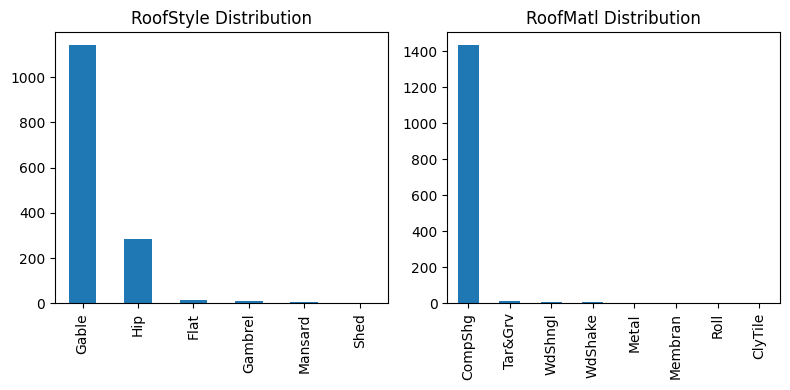

In [ ]:
roof_df = train_origin_df.copy() # change to the correct df

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
roof_df['RoofStyle'].value_counts().plot(kind='bar', ax=ax[0], title='RoofStyle Distribution')
roof_df['RoofMatl'].value_counts().plot(kind='bar', ax=ax[1], title='RoofMatl Distribution')
plt.tight_layout()
plt.show()

In [ ]:
# Grouping RoofStyle and RoofMatl to reduce categories
# Returns the same df but with the 2 new features *instead* of the 2 original ones

roof_df['RoofStyleGroup'] = roof_df['RoofStyle'].apply(lambda x: x if x in ['Gable', 'Hip'] else 'Other') # Converts into 3 groups
roof_df['RoofMatlGroup'] = roof_df['RoofMatl'].apply(lambda x: 'CompShg' if x == 'CompShg' else 'Other') # Converts into 2 groups

roof_df.drop(columns=['RoofStyle', 'RoofMatl'], inplace=True)

###Grouping neighborhoods by SalePrice

Sale prices varies significantly between neighborhoods. It might be beneficial to group similar neighborhoods to reduce data complexity without loosing significant information.

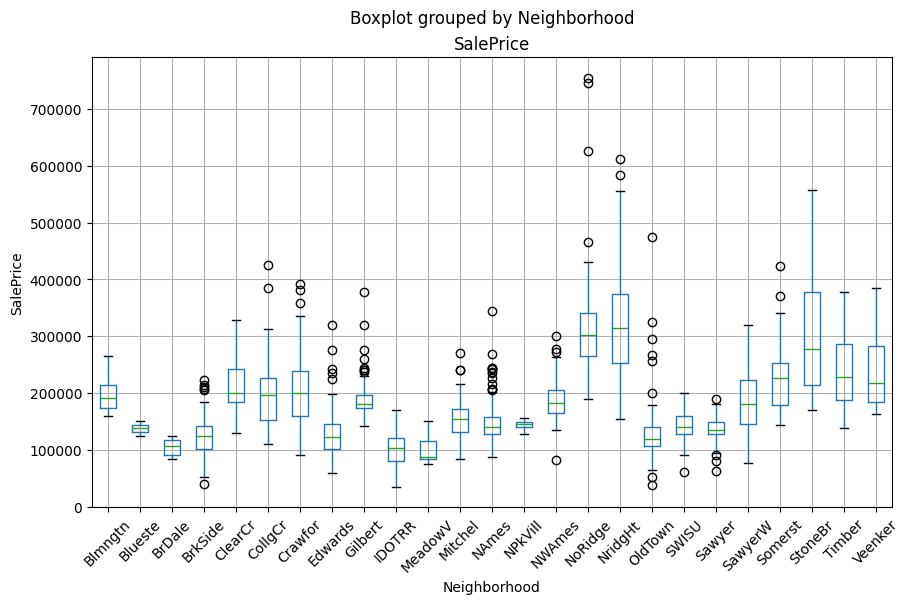

In [ ]:
from matplotlib import pyplot as plt
train_origin_df.boxplot(column='SalePrice', by='Neighborhood', figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('SalePrice')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Converting Neighborhoods into 3 groups (Low Medium High) by SalePrice
# Returns the same df but with the new feature ('NeighborhoodLevel') *instead* of original one ('Neighborhood')

neighborhood_groups_df = train_origin_df.copy() # replace with correct df

neighborhood_medians = neighborhood_groups_df.groupby('Neighborhood')['SalePrice'].median()

low_threshold = neighborhood_medians.quantile(0.33)
high_threshold = neighborhood_medians.quantile(0.66)

def assign_neighborhood_level(price):
    if price <= low_threshold:
        return 'Low'
    elif price <= high_threshold:
        return 'Medium'
    else:
        return 'High'

neighborhood_levels = neighborhood_medians.map(assign_neighborhood_level)
print(neighborhood_levels.sort_values())
neighborhood_groups_df['NeighborhoodLevel'] = neighborhood_groups_df['Neighborhood'].apply(lambda x: neighborhood_levels[x])
neighborhood_groups_df.drop(columns='Neighborhood', inplace=True)

Neighborhood
Veenker      High
NoRidge      High
Timber       High
Somerst      High
NridgHt      High
Crawfor      High
StoneBr      High
ClearCr      High
CollgCr      High
Edwards       Low
IDOTRR        Low
MeadowV       Low
BrkSide       Low
BrDale        Low
Sawyer        Low
Blueste       Low
OldTown       Low
SawyerW    Medium
Blmngtn    Medium
NWAmes     Medium
NPkVill    Medium
Mitchel    Medium
Gilbert    Medium
SWISU      Medium
NAmes      Medium
Name: SalePrice, dtype: object


###Engineering and Combining Asset Age features

There are 2 features that concern the "age" of the asset. They should have good correlation with the SalePrice, as new assets should be more expensive than old ones. Looking at their correlation with the target:

In [ ]:
age_df = train_origin_df.copy() # change to the correct df

print('YearBuilt-SalePrice correlation:', age_df['YearBuilt'].corr(age_df.SalePrice))
print('YearRemodAdd-SalePrice correlation:', age_df['YearRemodAdd'].corr(age_df.SalePrice))

YearBuilt-SalePrice correlation: 0.5228973328794969
YearRemodAdd-SalePrice correlation: 0.5071009671113865


Due to the fact that they have similar correlation with the target, it might be beneficial to combine them into one feature. Furthermore, it seems that these two values should be assessed with respect to another feature - 'YrSold'. The data expands over approximately 5 years, and this could mean a lot, mainly for newer (and therefore more expensive) buildings. Therefore, it might be beneficial to replace the two features with a new one - 'AssetAge'. Looking at the correlation of this new feature with the target, we see a similar value to the two original features, which suggests that this convertion preserves important information.

In [ ]:
# Creating new feature and dropping two original ones

age_df['AssetAge'] = age_df['YrSold'] - age_df[['YearBuilt', 'YearRemodAdd']].max(axis=1)
print('AssetAge-SalePrice correlation:', age_df['AssetAge'].corr(age_df.SalePrice))

age_df.drop(columns=['YearBuilt', 'YearRemodAdd'], inplace=True)

AssetAge-SalePrice correlation: -0.5090787380156292


###Golden triangle: Age-Size-Neighborhood

There are 3 features that may have a strong positive effect on the sale price:
1. Neighborhood (location)
2. Asset living area
3. Asset age (which also pretty much reflects its condition)

Combining these feature into one may introduce a compund effect on predicting - especially when using linear models (which wouldn't find by themselves such connections between these features).

In [ ]:
age_df = neighborhood_groups_df.copy() # change to the correct df

age_df['AssetAge'] = age_df['YrSold'] - age_df[['YearBuilt', 'YearRemodAdd']].max(axis=1)
print('AssetAge-SalePrice correlation:', age_df['AssetAge'].corr(age_df.SalePrice))

age_df.drop(columns=['YearBuilt', 'YearRemodAdd'], inplace=True)

AssetAge-SalePrice correlation: -0.5090787380156292


In [ ]:
# Creating a new feature 'GoldenTriangle' that captures non-linear connection between ['GrLivArea', 'YearsSinceRemodel', 'NeighborhoodLevelEncoded']
# We use the already grouped Neighborhood feature ('NeighborhoodLevel'), but encode it to ordinal numbers
# We use the already modified 'AssetAge' feature
# We need to normalize the two continuous features before combining all three
# Returns teh same df with the new feature but without the original 3

triangle_df = age_df.copy() # change to the correct df

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

# Normalize GrLivArea and AssetAge
scaler = MinMaxScaler()
triangle_df[['GrLivArea', 'AssetAge']] = scaler.fit_transform(triangle_df[['GrLivArea', 'AssetAge']])

# Encode NeighborhoodLevel
encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
triangle_df['NeighborhoodLevelEncoded'] = encoder.fit_transform(triangle_df[['NeighborhoodLevel']])

triangle_df['GoldenTriangle'] = triangle_df['GrLivArea'] * triangle_df['AssetAge'] * triangle_df['NeighborhoodLevelEncoded']

triangle_df.drop(columns=['GrLivArea', 'AssetAge', 'NeighborhoodLevelEncoded', 'NeighborhoodLevel'], inplace=True)